# Library Imports and setup

In [1]:
## Imports
import csv
import numbers
import os
import random
import pickle
from collections import OrderedDict, defaultdict
from copy import deepcopy
from pathlib import Path
from typing import *

import flwr as fl
import ray
import gdown
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.common import Metrics, Config, GetPropertiesIns, GetPropertiesRes, MetricsAggregationFn
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig, Server
from flwr.server.client_manager import SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion
from flwr.server.strategy import FedAvgM as FedAvg
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337

np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False # type: ignore
torch.backends.cudnn.deterministic = True # type: ignore

def start_seeded_simulation(
    client_fn,
    num_clients,
    client_resources,
    server,
    config,
    strategy,
    seed: int = Seeds.DEFAULT,
):
    """Wrapper to always seed client selection."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources=client_resources,
        server=server,
        config=config,
        strategy=strategy,
    )

def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT, **kwargs):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)

PathType = Optional[Union[Path, str]]

def get_device() -> str:
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

# File path setup

In [2]:
# home_dir = Path("/content")
home_dir = Path("/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/FedBuffExperiments")
devices_info_dir: Path = home_dir / "device_info"
statistical_utility: Path = home_dir / "statistical_utility.csv"
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

# Local imports

In [3]:
from client import FlowerRayClient, get_flower_client_generator
from client_manager import CustomClientManager
from strategy import FedAvgTraces, FedBuffTraces
from client_utils import get_network_generator_cnn, get_model_parameters, aggregate_weighted_average, get_federated_evaluation_function,get_default_test_config, get_default_train_config

# System trace loading

In [4]:
def get_devices_info(
    root_dir: Path,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """The function retrieves two pandas data frames containing
    traces and capabilities of clients' devices.

    Args:
        root_dir (Path): path to the folder containing such traces.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: couple of dataframes containg the requeste info
    """    
    cbt_path = root_dir/'client_behave_trace'
    cdc_path = root_dir/'client_device_capacity'
    with open(cbt_path, 'rb') as f:
        client_behave_trace = pd.DataFrame(pickle.load(f)).transpose()
    with open(cdc_path, 'rb') as f:
        client_device_capacity = pd.DataFrame(pickle.load(f)).transpose()
    return client_behave_trace, client_device_capacity

def isActive(
    single_client_traces: Dict[str, Any],
    current_clock_time: int,
    ) -> bool:
    """The function returns a boolean describing whether the client is active or not.
    It returns True when `single_client_traces` are not given.
    The current (virtual) clock time must pass as a parameter.

    Args:
        single_client_traces (Dict[str, Any]): dictionary describing client device traces.
        current_clock_time (int): parameter that describes current (virtual) clock time.

    Returns:
        bool: True is the client is active, False elsewhere.
    """    
    # If no traces are given, return True
    if single_client_traces is None:
        return True
    # Get the normalized time when the `current_clock_time` is
    # greater than `single_client_traces['finish_time']`, nothing
    # happens if `current_clock_time` < `single_client_traces['finish_time']`
    normalized_time = current_clock_time % single_client_traces['finish_time']
    # Get the highest single_client_traces['active'] occurrence
    # that is lower than `normalized_time`
    single_client_traces['active'].sort()
    active_time = -1
    for t in single_client_traces['active']:
        active_time = t if t <= normalized_time else active_time
    # print(f"Highest active time: {active_time}")
    # Get the highest single_client_traces['inactive'] occurrence
    # that is lower than `normalized_time`
    single_client_traces['inactive'].sort()
    inactive_time = -1
    for t in single_client_traces['inactive']:
        inactive_time = t if t <= normalized_time else inactive_time
    # print(f"Highest inactive time: {inactive_time}")

    return active_time > inactive_time

def get_client_completion_time(
    single_client_device_capacity: Dict[str, Any],
    batch_size: int,
    n_batches: int,
    model_size: float,
    augmentation_factor: float = 3.0,
    model_size_scale_factor: float = 1.0
) -> Dict[str, float]:
    """The function computes the computation and communication latency of the client.
    These values are computed as follows:
    
    - Computation latency: `single_client_device_capacity['computation']` is the inference latency of models (ms/sample).
                            We compute the computation latency as the inference latency times the number of samples processed.
                            As reported in many papers, backwards-pass takes around 2x the latency, so we multiply it by 3x.
    - Communication latency: `single_client_device_capacity['communication']` represents the bandwidth of the device (kB/s).
                            We then compute the communication latency as the ratio between twice the size of the model and
                            the bandwidth of the device.
            
    Args:
        single_client_device_capacity (Dict[str, Any]): dictionary containing info about device capabilities.
        batch_size (int): batch size used during local client training.
        n_batches (int): number of batches trained by the client.
        model_size (float): an estimate of the size of the model in MB.
        augmentation_factor (float, optional): _description_. Defaults to 3.0.

    Returns:
        Dict[str, float]: dictionary containing estimates for time spent by the client in computation and communication.
    """
    return {'computation': augmentation_factor * batch_size * n_batches * float(single_client_device_capacity['computation'])/1000.,
            'communication': 2 * model_size_scale_factor * model_size * 1000 / float(single_client_device_capacity['communication'])}

client_behave_trace, client_device_capacity = get_devices_info(devices_info_dir)
# NOTE: setting random state does NOT make this return the same thing every run!
client_device_capacity = client_device_capacity.sample(len(client_behave_trace), replace=False, random_state=Seeds.DEFAULT)

# Simulating real devices using traces

## Sync Client

In [5]:
class FlowerRayClientTraces(FlowerRayClient):
    def __init__(
        self,
        cid: int,
        data_dir: Path,
        partition_dir: Path,
        model_generator: Callable[[], Module],
        single_client_device_capacity: Dict[str, Any],
        single_client_traces: Dict[str, Any],
        verbose: bool = False,
    ) -> None:
        """Function to initialise the client with its unique id
        and the directory from which it can load its data.
        Device capabilities and traces are also passed to the client.

        Args:
            data_dir (Path): path to the dataset folder.
            cid (int): Unique client id for a client used to map it to its data partition
            partition_dir (Path): The directory containing data for each client/client id
            model_generator (Callable[[], Module]): The model generator function
            single_client_device_capacity (Dict[str, Any]): dictionary containing info about device capabilities.
            single_client_traces (Dict[str, Any]): dictionary describing client device traces.
            verbose (bool): boolean describing whether the client should print or not.
        """
        super().__init__(cid, data_dir, partition_dir, model_generator)
        self.device_capacity = single_client_device_capacity
        self.trace = single_client_traces
        self.verbose = verbose
        self.properties: Dict[str, Scalar] = { # type: ignore
            "tensor_type": "numpy.ndarray",
            "cid": self.cid,
            "device_capacity": self.device_capacity,
            "traces": self.trace,
            }

    def fit(
        self, parameters: NDArrays, config: Dict[str, Scalar], **kwargs
    ) -> Tuple[NDArrays, int, dict]:
        """Function which receives and trains a model on the local client data using parameters from the config dict.
        Before training, the function checks if the client is active at the current time step.

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the training parameters

        Returns:
            Tuple[NDArrays, int, dict]: Returns the updated model, the size of the local dataset and other metrics
        """

        # We need to include model size to compute communications costs
        # As part of our systems-aware simulation
        # Importantly, since Flower now accepts failures this will only cause the client to return a failure
        if "model_size" not in config:
            raise Exception("Model size not found in config")
        
        # We need to compute the number of samples in the training set
        # As such we set n_batches to the number of batches which the set contains
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config['batch_size']),
            n_batches=int(int(config['epochs'])*self.get_train_set_size()/int(config['batch_size'])),
            model_size=float(config['model_size']),
        )
        # Add up the communication and computation times
        total_time = completion_time['communication']+completion_time['computation']

        # Store the result in the trace
        self.trace['duration'] = total_time

        if self.verbose:
            print(f"Client {self.cid} --- Current virtual clock time: {config['current_virtual_clock']}")
            print(f"Client {self.cid} --- Duration: {total_time}")
            print(f"Client {self.cid} --- Traces: {self.trace}")
            print(f"Client {self.cid} --- Predicted completion: {int(config['current_virtual_clock'])+int(total_time)}")
            print(f"Client {self.cid} --- isActive: {isActive(self.trace, int(config['current_virtual_clock'])+int(total_time))}")
        if "current_virtual_clock" not in config:
            raise Exception("Current virtual clock not found in config")
        if not isActive(self.trace, int(config["current_virtual_clock"])+int(total_time)):
            raise Exception(f"Client {self.cid} is not active at the current time step")
        
        params, n_samples, results = super().fit(parameters, config)
        results.update({
            "client_completion_time": total_time,
            "computation": self.device_capacity['computation'],
            "communication": self.device_capacity['communication'],
            "cid": self.cid,
        })
        return params, n_samples, results

    def evaluate(
        self, parameters: NDArrays, config: Dict[str, Scalar], **kwargs
    ) -> Tuple[float, int, dict]:
        """Function which receives and tests a model on the local client data using parameters from the config dict
        Before testing, the function checks if the client is active at the current time step.

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the testing parameters

        Returns:
            Tuple[float, int, dict]: Returns the loss accumulate during testing, the size of the local dataset and other metrics such as accuracy
        """
        if "model_size" not in config:
            raise Exception("Model size not found in config")
        
        # Estimate time based on number of batches in dataset
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config['batch_size']),
            n_batches=int(self.get_test_set_size()/int(config['batch_size'])),
            model_size=float(config['model_size']),
        )

        # Compute total time
        total_time = completion_time['communication']+completion_time['computation']

        # Store result in trace
        self.trace['duration'] = total_time
        if self.verbose:
            print(f"Client {self.cid} --- Current virtual clock time: {config['current_virtual_clock']}")
            print(f"Client {self.cid} --- Duration: {total_time}")
            print(f"Client {self.cid} --- Traces: {self.trace}")
            print(f"Client {self.cid} --- Predicted completion: {int(config['current_virtual_clock'])+int(total_time)}")
            print(f"Client {self.cid} --- isActive: {isActive(self.trace, int(config['current_virtual_clock'])+int(total_time))}")
        if "current_virtual_clock" not in config:
            raise Exception("Current virtual clock not found in config")
        if not isActive(self.trace, int(config["current_virtual_clock"])+int(total_time)):
            raise Exception(f"Client {self.cid} is not active at the current time step")
        
        loss, n_samples, results = super().evaluate(parameters, config)
        results.update({
            "client_completion_time": total_time,
            "computation": self.device_capacity['computation'],
            "communication": self.device_capacity['communication'],
            "cid": self.cid,
        })
        return loss, n_samples, results

## Client generator

In [6]:
def get_flower_client_with_traces_generator(
    clients_device_capacity: List[Dict[str, Any]],
    clients_traces: List[Dict[str, Any]],
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Optional[Callable[[int], int]] = None, # IGNORED
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        clients_device_capacity (List[Dict[str, Any]]): list containing the clients device capabilities.
        clients_traces (List[Dict[str, Any]]): list containing the clients traces.
        data_dir (Path): path to the datasßet folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], FlowerRayClient]: client instance.
    """
    def client_fn(cid: str) -> FlowerRayClientTraces:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns:
            FlowerRayClientTraces: client instance.
        """
        print(f"Getting client with id {cid}")
        client = FlowerRayClientTraces(
            # NOTE: passing the called `cid` here to allow for different mapping between data and devices
            single_client_device_capacity=clients_device_capacity[int(cid)],
            single_client_traces=clients_traces[int(cid)],
            # NOTE: the mapping is only applied here, this is due to control the data mapping
            cid=int(cid),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
            # NOTE: you may want to comment out the following line or to set the verbosity to False
            verbose=True,
        )
        
        client.device = get_device()
        return client

    return client_fn

## Activity criterion

In [7]:
class ActivityCriterion(Criterion):
    """This class implements the Template criterion."""
    
    def __init__(self, client_traces) -> None:
        """Initializes the Template criterion."""
        self.current_virtual_clock = 0
        self.client_traces = client_traces
    
    def select(self, client: ClientProxy) -> bool:
        """Selects the client that receives if it is active.
        Before selecting it, the function gets the `properties` of the client.

        Args:
            client (ClientProxy): client proxy to select.

        Returns:
            bool: True if the client is selected, False otherwise.
        """        
        # request_properties: Config = {
        #     # Here goes the template of the client properties
        #     "tensor_type": "str",
        #     "cid": "str",
        #     "device_capacity": "Dict[str, Any]",
        #     "traces": "Dict[str, Any]",
        #     }
        # ins: GetPropertiesIns = GetPropertiesIns(
        #     config=request_properties
        # )
        # # This contains the client properties
        # value: GetPropertiesRes = client.get_properties(ins, timeout=None)
        # # NOTE: here we use `isActive` to check if the client is active at the current time step
        # return isActive(value.properties['traces'], self.current_virtual_clock) # type: ignore
        
        traces = self.client_traces[int(client.cid)]
        return isActive(traces, self.current_virtual_clock)

## Run the simulation

### Generators

In [8]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)

federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=get_default_test_config()["batch_size"],
    num_workers=get_default_test_config()["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)

# NOTE: we are using here the `get_flower_client_with_traces_generator`
num_total_clients = 3229
sampled_cdc = client_device_capacity.sample(num_total_clients, replace=False, random_state=Seeds.DEFAULT)
sampled_cbt = client_behave_trace.sample(num_total_clients, replace=False, random_state=Seeds.DEFAULT)

device_capacity_dict = sampled_cdc.to_dict('records')
behave_traces_dict = sampled_cbt.to_dict('records')

flower_client_with_traces_generator: Callable[
    [int], FlowerRayClientTraces
] = get_flower_client_with_traces_generator(
    clients_device_capacity=device_capacity_dict, # type: ignore
    clients_traces=behave_traces_dict, # type: ignore
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=federated_partition) # type: ignore

## CONFIG OPTIONS

train_config = get_default_train_config()
train_config.update({
        "model_size": 1000,
        "current_virtual_clock": 0.0,
    })
test_config = get_default_test_config()
test_config.update({
        "model_size": 1000,
        "current_virtual_clock": 0.0,
    })

on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config
on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: test_config # type: ignore

### Run simulations

In [9]:
def run_simulation(asynchronous, concurrency, num_rounds, K=10):
    num_clients_per_round: int = concurrency
    num_evaluate_clients: int = 0
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    # fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
    fraction_evaluate: float = 0.0

    accept_failures = True
    min_fit_clients = concurrency
    min_available_clients = concurrency
    initial_parameters: Parameters = ndarrays_to_parameters(seed_model_cnn_params)
    # maximum amount of resources that a client can take
    client_resources = {
        "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0,
        "num_cpus": 1,
    }

    if not asynchronous:
        strategy = FedAvgTraces(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_available_clients=min_available_clients,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            initial_parameters=initial_parameters,
            accept_failures=accept_failures,
            evaluate_fn=federated_evaluation_function,
            fit_metrics_aggregation_fn=aggregate_weighted_average,
            evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        )
    else:
        strategy = FedBuffTraces(
            concurrency=concurrency,
            buffer_size=K,
            on_fit_config_fn=on_fit_config_fn,
            initial_parameters=initial_parameters,
            accept_failures=accept_failures,
            evaluate_fn=federated_evaluation_function,
            fit_metrics_aggregation_fn=aggregate_weighted_average,
        )

    criterion = ActivityCriterion(behave_traces_dict)
    client_manager = CustomClientManager(criterion=criterion, seed=Seeds.DEFAULT)

    server = Server(
        client_manager=client_manager,
        strategy=strategy,
        asynchronous=asynchronous,
    )
    hist =  start_seeded_simulation(
        client_fn=flower_client_with_traces_generator,
        num_clients=num_total_clients,
        client_resources=client_resources,
        server=server,
        config=ServerConfig(num_rounds=num_rounds, asynchronous=asynchronous),
        strategy=strategy,
    )

    sim_type = "async" if asynchronous else "sync"
    filename = f"saves/{sim_type}_hist_{concurrency}"
    torch.save(hist, filename)
    return hist

In [10]:
# # del FedBuffTraces
# import sys
# try:
#     del sys.modules['FedBuffTraces']
# except AttributeError:
#     print("Not in cache")
# import FedBuffTraces
# from strategy import FedAvgTraces, FedBuffTraces
# sorted(list(sys.modules.keys()))
# del FedBuffTraces
# sys.modules[FedBuffTraces]

In [13]:
run_simulation(True, 20, 10)

817915 WARNING flwr 2023-03-23 13:11:38,132 | app.py:208 | Both server and strategy were provided, ignoring strategy
817915 INFO flwr 2023-03-23 13:11:38,133 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None, asynchronous=True)
2023-03-23 13:11:40,114	INFO worker.py:1553 -- Started a local Ray instance.
817915 INFO flwr 2023-03-23 13:11:41,251 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 1328898048.0, 'memory': 2657796096.0, 'node:10.9.7.124': 1.0}
817915 INFO flwr 2023-03-23 13:11:41,268 | server.py:95 | Initializing global parameters
817915 INFO flwr 2023-03-23 13:11:41,268 | server.py:316 | Using initial parameters provided by strategy
817915 INFO flwr 2023-03-23 13:11:41,269 | server.py:97 | Evaluating initial parameters


Server round 0


817915 INFO flwr 2023-03-23 13:11:49,522 | server.py:100 | initial parameters (loss, other metrics): 3686.0015926361084, {'accuracy': 0.005892669238863556, 'eval_time': 0.0}
817915 INFO flwr 2023-03-23 13:11:49,523 | server.py:110 | FL starting
817915 INFO flwr 2023-03-23 13:11:49,529 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b41429870>
817915 DEBUG flwr 2023-03-23 13:11:49,531 | server.py:255 | fit_round 1: strategy sampled 20 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:11:49,532 | server.py:435 | Sending instructions to clients


Want 20 more clients, minimum 20
Sampled the following clients:  ['2907', '2338', '678', '447', '267', '1872', '2471', '2614', '2674', '70', '3068', '1366', '2645', '3016', '3080', '2330', '1053', '614', '1761', '1422']
Selected clients = ['2907', '2338', '678', '447', '267', '1872', '2471', '2614', '2674', '70', '3068', '1366', '2645', '3016', '3080', '2330', '1053', '614', '1761', '1422']


817915 DEBUG flwr 2023-03-23 13:11:53,166 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=818269, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 2338 is not active at the current time step
817915 DEBUG flwr 2023-03-23 13:11:53,194 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=818272, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_

(launch_and_fit pid=818269) Getting client with id 2338
(launch_and_fit pid=818269) Client 2338 --- Current virtual clock time: 0.0
(launch_and_fit pid=818269) Client 2338 --- Duration: 330.8692435902733
(launch_and_fit pid=818269) Client 2338 --- Traces: {'duration': 330.8692435902733, 'inactive': [253, 9592, 37101, 91574, 98507, 99602, 108811, 109252, 110440, 110455, 110506, 123147, 124397, 181054, 184391, 211985, 279612, 279669, 296409, 310923], 'finish_time': 345600, 'active': [0, 6012, 10661, 90284, 96605, 98510, 101123, 109247, 110416, 110451, 110490, 110515, 124393, 178759, 181739, 186827, 279538, 279635, 279695, 296435], 'model': 'vivo 1724'}
(launch_and_fit pid=818269) Client 2338 --- Predicted completion: 330
(launch_and_fit pid=818269) Client 2338 --- isActive: False
(launch_and_fit pid=818274) Getting client with id 678
(launch_and_fit pid=818274) Client 678 --- Current virtual clock time: 0.0
(launch_and_fit pid=818274) Client 678 --- Duration: 1087.5163560740814
(launch_a

817915 DEBUG flwr 2023-03-23 13:12:03,975 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=821123, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 3080 is not active at the current time step


(launch_and_fit pid=821123) Getting client with id 3080
Client finshed: 3080
(launch_and_fit pid=821123) Client 3080 --- Current virtual clock time: 0.0
(launch_and_fit pid=821123) Client 3080 --- Duration: 1658.6356404363478
(launch_and_fit pid=821123) Client 3080 --- Traces: {'duration': 1658.6356404363478, 'inactive': [31, 62, 93, 124, 2153, 2184, 2215, 2246, 4063, 6426, 8880, 8942, 11333, 11364, 11395, 12999, 47644, 49447, 51519, 111418, 119250, 126570, 132483, 143572, 187772, 187804, 187836, 187959, 187965, 224544, 224573, 282452, 401372, 421770, 421800, 423921, 426133, 427811, 474903, 476167], 'finish_time': 518400, 'active': [0, 31, 62, 93, 124, 2153, 2184, 2215, 2246, 4064, 6427, 8880, 8942, 11333, 11365, 11402, 47355, 48702, 50298, 105538, 118401, 126460, 126610, 142402, 174786, 187772, 187804, 187840, 187959, 214380, 224545, 277862, 400110, 409174, 421770, 421800, 423922, 426133, 469501, 474903], 'model': 'SM-J530G'}
(launch_and_fit pid=821123) Client 3080 --- Predicted compl

817915 DEBUG flwr 2023-03-23 13:12:10,605 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:12:10,606 | server.py:279 | fit_round 1 received 16 results and 4 failures
817915 INFO flwr 2023-03-23 13:12:10,607 | strategy.py:360 | Completion times of clients: [160.747556474767, 295.38546088216066, 377.30695591923774, 408.85021958356475, 511.7667562372511, 578.3162085762331, 653.9093580981513, 690.6745990119305, 748.0411889634006, 791.9906866913011]
817915 INFO flwr 2023-03-23 13:12:10,608 | strategy.py:362 | Maximum completion time of clients: 791.9906866913011


Client finshed: 614
These clients sent updates: [('2674', 0), ('1366', 0), ('614', 0), ('1053', 0), ('2907', 0), ('1422', 0), ('447', 0), ('1761', 0), ('1872', 0), ('2330', 0)]
These clients failed: ['2338', '70', '267', '3080']
Server round 1


817915 INFO flwr 2023-03-23 13:12:18,501 | server.py:140 | fit progress: (1, 3424.019745826721, {'accuracy': 0.06976499473868818, 'eval_time': 791.9906866913011}, 28.977327348999097)
817915 INFO flwr 2023-03-23 13:12:18,503 | server.py:190 | evaluate_round 1: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:12:18,510 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b417adde0>
817915 DEBUG flwr 2023-03-23 13:12:18,512 | server.py:255 | fit_round 2: strategy sampled 14 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:12:18,512 | server.py:435 | Sending instructions to clients


Want 14 more clients, minimum 14
Sampled the following clients:  ['75', '796', '2035', '665', '2040', '2902', '2962', '2258', '1196', '1462', '1075', '2957', '2608', '2991']
Selected clients = ['75', '796', '2035', '665', '2040', '2902', '2962', '2258', '1196', '1462', '1075', '2957', '2608', '2991']
(launch_and_fit pid=826829) Getting client with id 2035
(launch_and_fit pid=826828) Getting client with id 796
(launch_and_fit pid=826827) Getting client with id 2902
(launch_and_fit pid=826829) Client 2035 --- Current virtual clock time: 791.9906866913011
(launch_and_fit pid=826829) Client 2035 --- Duration: 104.8773233736289
(launch_and_fit pid=826829) Client 2035 --- Traces: {'duration': 104.8773233736289, 'inactive': [3413, 51677, 51706, 70328, 122990], 'finish_time': 172800, 'active': [0, 51659, 51689, 52825, 110209], 'model': 'CPH1909'}
(launch_and_fit pid=826829) Client 2035 --- Predicted completion: 895
(launch_and_fit pid=826829) Client 2035 --- isActive: True
(launch_and_fit pid=

817915 DEBUG flwr 2023-03-23 13:12:23,767 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=826832, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 665 is not active at the current time step
817915 DEBUG flwr 2023-03-23 13:12:23,815 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=826834, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_p

(launch_and_fit pid=826832) Getting client with id 665
(launch_and_fit pid=826832) Client 665 --- Current virtual clock time: 791.9906866913011
(launch_and_fit pid=826832) Client 665 --- Duration: 1456.9034748613306
(launch_and_fit pid=826832) Client 665 --- Traces: {'duration': 1456.9034748613306, 'inactive': [1166, 52875], 'finish_time': 86400, 'active': [0, 43797], 'model': 'CPH1803'}
(launch_and_fit pid=826832) Client 665 --- Predicted completion: 2247
(launch_and_fit pid=826832) Client 665 --- isActive: False
(launch_and_fit pid=826833) Getting client with id 2962
(launch_and_fit pid=826833) Client 2962 --- Current virtual clock time: 791.9906866913011
(launch_and_fit pid=826833) Client 2962 --- Duration: 137.58885831410655
(launch_and_fit pid=826833) Client 2962 --- Traces: {'duration': 137.58885831410655, 'inactive': [15290], 'finish_time': 86400, 'active': [671], 'model': 'Lenovo TB-7304I'}
(launch_and_fit pid=826833) Client 2962 --- Predicted completion: 928
(launch_and_fit pi

817915 DEBUG flwr 2023-03-23 13:12:30,129 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=827406, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 2258 is not active at the current time step


(launch_and_fit pid=827449) Getting client with id 1075
(launch_and_fit pid=827449) Client 1075 --- Current virtual clock time: 791.9906866913011
(launch_and_fit pid=827449) Client 1075 --- Duration: 446.4704257051686
(launch_and_fit pid=827449) Client 1075 --- Traces: {'duration': 446.4704257051686, 'inactive': [205, 2521, 16597, 34432, 35295, 35821, 43411, 44953, 63531], 'finish_time': 86400, 'active': [204, 238, 9502, 34363, 34472, 35589, 42756, 43440, 61431], 'model': 'Infinix X653C'}
(launch_and_fit pid=827449) Client 1075 --- Predicted completion: 1237
(launch_and_fit pid=827449) Client 1075 --- isActive: True
Client finshed: 2258
(launch_and_fit pid=827406) Getting client with id 2258
(launch_and_fit pid=827406) Client 2258 --- Current virtual clock time: 791.9906866913011
(launch_and_fit pid=827406) Client 2258 --- Duration: 1032.0027001792835
(launch_and_fit pid=827406) Client 2258 --- Traces: {'duration': 1032.0027001792835, 'inactive': [1448, 25501, 26440, 28876, 28959, 2900

817915 DEBUG flwr 2023-03-23 13:12:31,848 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=829679, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 1462 is not active at the current time step


Client finshed: 1462
(launch_and_fit pid=829679) Getting client with id 1462
(launch_and_fit pid=829679) Client 1462 --- Current virtual clock time: 791.9906866913011
(launch_and_fit pid=829679) Client 1462 --- Duration: 1599.9649468094608
(launch_and_fit pid=829679) Client 1462 --- Traces: {'duration': 1599.9649468094608, 'inactive': [343, 1567, 20080, 20897, 24862, 88888, 89994, 90148, 90320, 90464, 91484, 92283, 130646, 130771, 130945, 132158, 132253, 132267, 132584, 132621, 132647, 132735, 132738, 133264, 133781, 133992, 134081, 134159, 134188, 146280, 150840], 'finish_time': 172800, 'active': [0, 546, 6552, 20082, 20898, 88843, 88889, 89994, 90205, 90320, 90464, 91736, 130597, 130647, 130772, 130946, 132158, 132253, 132459, 132605, 132622, 132648, 132735, 132778, 133285, 133846, 133993, 134084, 134161, 138496, 146291], 'model': 'SM-J810M'}
(launch_and_fit pid=829679) Client 1462 --- Predicted completion: 2390
(launch_and_fit pid=829679) Client 1462 --- isActive: False
(launch_and_

817915 DEBUG flwr 2023-03-23 13:12:32,352 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=829721, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 2957 is not active at the current time step


(launch_and_fit pid=829830) Getting client with id 2991
(launch_and_fit pid=829830) Client 2991 --- Current virtual clock time: 791.9906866913011
(launch_and_fit pid=829830) Client 2991 --- Duration: 118.95488573942433
(launch_and_fit pid=829830) Client 2991 --- Traces: {'duration': 118.95488573942433, 'inactive': [9, 84, 105, 130, 320, 423, 551, 606, 646, 708, 781, 813, 836, 939, 1025, 1338, 1390, 4503, 6201, 7277, 7455, 7701, 8187, 8290, 8294, 8330, 9691, 9705, 9774, 9830, 9849, 10074, 10102, 10108, 10159, 10224, 10254, 12847, 13482, 13505, 14332, 14376, 14480, 14519, 14550, 14604, 57916, 57963, 58000, 58068, 58248, 58269, 58464, 58767, 59008, 59265, 63811, 65985, 65990, 86702, 86806, 87175, 88517, 88575, 89495, 89541, 103039, 103069, 103094, 108796, 110959, 111477, 111528, 112391, 119335, 120515, 120523, 120879, 131104, 131164, 139373, 141593, 142200, 142625, 144742, 154508, 154568, 154579, 157046, 173000, 173810, 174051, 207207, 207217, 235952, 242050, 242071, 242368, 243082, 24615

817915 DEBUG flwr 2023-03-23 13:12:33,592 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:12:33,594 | server.py:279 | fit_round 2 received 9 results and 5 failures
817915 INFO flwr 2023-03-23 13:12:33,596 | strategy.py:360 | Completion times of clients: [104.8773233736289, 118.95488573942433, 136.80537284954332, 137.58885831410655, 296.5387975793243, 446.4704257051686, 665.9818215907752, 967.1871108575064, 1049.8973331279187, 1087.5163560740814]
817915 INFO flwr 2023-03-23 13:12:33,598 | strategy.py:362 | Maximum completion time of clients: 1087.5163560740814


Client finshed: 2608
Client finshed: 2991
These clients sent updates: [('2035', 0), ('2991', 0), ('2608', 0), ('2962', 0), ('796', 0), ('1075', 0), ('2902', 0), ('2471', 1), ('2040', 0), ('678', 1)]
These clients failed: ['665', '1196', '2258', '1462', '2957']
Server round 2


817915 INFO flwr 2023-03-23 13:12:40,903 | server.py:140 | fit progress: (2, 3096.1242578029633, {'accuracy': 0.07969133637320239, 'eval_time': 1879.5070427653825}, 51.37929765699846)
817915 INFO flwr 2023-03-23 13:12:40,905 | server.py:190 | evaluate_round 2: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:12:40,913 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b46aabbe0>
817915 DEBUG flwr 2023-03-23 13:12:40,915 | server.py:255 | fit_round 3: strategy sampled 15 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:12:40,915 | server.py:435 | Sending instructions to clients


Want 15 more clients, minimum 15
Sampled the following clients:  ['2517', '1401', '2988', '529', '421', '756', '808', '934', '3098', '2853', '1150', '925', '632', '2618', '224']
Selected clients = ['2517', '1401', '2988', '529', '421', '756', '808', '934', '3098', '2853', '1150', '925', '632', '2618', '224']
(launch_and_fit pid=831725) Getting client with id 808
(launch_and_fit pid=831725) Client 808 --- Current virtual clock time: 1879.5070427653825
(launch_and_fit pid=831725) Client 808 --- Duration: 481.106196547328
(launch_and_fit pid=831725) Client 808 --- Traces: {'duration': 481.106196547328, 'inactive': [1793, 1861, 1894, 2995, 3246, 3327, 3418, 3576, 5701, 8858, 18719, 18971, 114797, 116893, 120333, 175338, 178028, 190302, 191645, 224188, 243291, 282621, 339453, 339879, 341339], 'finish_time': 345600, 'active': [695, 1794, 1863, 2011, 2995, 3246, 3336, 3419, 3577, 7323, 10388, 18719, 114688, 114798, 116894, 175078, 175339, 189288, 190302, 220875, 224192, 276571, 336714, 339463

817915 DEBUG flwr 2023-03-23 13:12:47,001 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=831724, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 756 is not active at the current time step
817915 DEBUG flwr 2023-03-23 13:12:47,044 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=831720, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_p

(launch_and_fit pid=831724) Getting client with id 756
Client finshed: 756
Client finshed: 1401
(launch_and_fit pid=831724) Client 756 --- Current virtual clock time: 1879.5070427653825
(launch_and_fit pid=831724) Client 756 --- Duration: 1122.342484893987
(launch_and_fit pid=831724) Client 756 --- Traces: {'duration': 1122.342484893987, 'inactive': [2951, 34884, 36405, 77748, 90613, 118446, 162154, 273158, 426049], 'finish_time': 432000, 'active': [33, 31623, 36163, 41018, 89477, 116391, 157624, 173200, 423455], 'model': 'SM-J415G'}
(launch_and_fit pid=831724) Client 756 --- Predicted completion: 3001
(launch_and_fit pid=831724) Client 756 --- isActive: False
(launch_and_fit pid=831719) Getting client with id 2517
(launch_and_fit pid=831720) Getting client with id 1401
(launch_and_fit pid=831720) Client 1401 --- Current virtual clock time: 1879.5070427653825
(launch_and_fit pid=831720) Client 1401 --- Duration: 496.2619499792847
(launch_and_fit pid=831720) Client 1401 --- Traces: {'du

817915 DEBUG flwr 2023-03-23 13:13:01,291 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=834993, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 224 is not active at the current time step


(launch_and_fit pid=834246) Getting client with id 3098
(launch_and_fit pid=834246) Client 3098 --- Current virtual clock time: 1879.5070427653825
(launch_and_fit pid=834246) Client 3098 --- Duration: 563.2674644510255
(launch_and_fit pid=834246) Client 3098 --- Traces: {'duration': 563.2674644510255, 'inactive': [1764, 1933, 2095, 2755, 2806, 2814, 2867, 3019, 3272, 3399, 3471, 3498, 4077, 4131, 4582, 4762, 4780, 4824, 4875, 4894, 5086, 5125, 5393, 5423, 5485, 5508, 5531, 5661, 5709, 5769, 5818, 5846, 5868, 5909, 5966, 6072, 6076, 6598, 7000, 7025, 7102, 7149, 7165, 7267, 7372, 7504, 7545, 7609, 7715, 7742, 7847, 7971, 8062, 8092, 8131, 8150, 8427, 8582, 8864, 8903, 9293, 9565, 9580, 9648, 9673, 9725, 9784, 9808, 9848, 9873, 9896, 9916, 9952, 9976, 10010, 10023, 10051, 10117, 10240, 10286, 10317, 10388, 10411, 10448, 10479, 10504, 10582, 10638, 10671, 10698, 10869, 10887, 10998, 11162, 11204, 11242, 11334, 11428, 11495, 11516, 11563, 11605, 11719, 11762, 11800, 11901, 11944, 11981, 12

817915 DEBUG flwr 2023-03-23 13:13:04,140 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:13:04,142 | server.py:279 | fit_round 3 received 10 results and 3 failures
817915 INFO flwr 2023-03-23 13:13:04,144 | strategy.py:360 | Completion times of clients: [244.82024872989444, 370.3212014721119, 421.49277614204607, 481.106196547328, 525.7401592703895, 563.474196547328, 674.7452167252973, 904.8614010515907, 1391.952242700838, 1402.9223304679922]
817915 INFO flwr 2023-03-23 13:13:04,146 | strategy.py:362 | Maximum completion time of clients: 1402.9223304679922


Client finshed: 2618
Client finshed: 1150
These clients sent updates: [('2517', 0), ('1150', 0), ('2618', 0), ('808', 0), ('925', 0), ('934', 0), ('2988', 0), ('2853', 0), ('2614', 2), ('3016', 2)]
These clients failed: ['756', '1401', '224']
Server round 3


817915 INFO flwr 2023-03-23 13:13:13,012 | server.py:140 | fit progress: (3, 3086.910759449005, {'accuracy': 0.07976148719747457, 'eval_time': 3282.4293732333745}, 83.48812474399892)
817915 INFO flwr 2023-03-23 13:13:13,014 | server.py:190 | evaluate_round 3: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:13:13,025 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b4142bf10>
817915 DEBUG flwr 2023-03-23 13:13:13,029 | server.py:255 | fit_round 4: strategy sampled 13 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:13:13,030 | server.py:435 | Sending instructions to clients


Want 13 more clients, minimum 13
Sampled the following clients:  ['144', '2040', '2455', '2858', '1806', '1279', '2100', '2931', '2491', '2011', '2868', '272', '524']
Selected clients = ['144', '2040', '2455', '2858', '1806', '1279', '2100', '2931', '2491', '2011', '2868', '272', '524']
Client finshed: 3098
Client finshed: 632
(launch_and_fit pid=838115) Getting client with id 2100
(launch_and_fit pid=838115) Client 2100 --- Current virtual clock time: 3282.4293732333745
(launch_and_fit pid=838115) Client 2100 --- Duration: 591.3416719152932
(launch_and_fit pid=838115) Client 2100 --- Traces: {'duration': 591.3416719152932, 'inactive': [4692, 38316, 69881, 77756, 80233, 97987, 135913, 164287, 209650, 241165, 248473, 251347], 'finish_time': 259200, 'active': [2306, 4791, 66425, 76943, 77773, 90561, 128914, 157925, 182272, 240262, 241219, 248478], 'model': 'Redmi S2'}
(launch_and_fit pid=838115) Client 2100 --- Predicted completion: 3873
(launch_and_fit pid=838115) Client 2100 --- isActi

817915 DEBUG flwr 2023-03-23 13:13:25,074 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:13:25,075 | server.py:279 | fit_round 4 received 10 results and 0 failures
817915 INFO flwr 2023-03-23 13:13:25,077 | strategy.py:360 | Completion times of clients: [344.06996359302406, 563.2674644510255, 591.3416719152932, 687.1078649236786, 745.5440256950537, 915.237395995364, 1012.8388777623468, 1049.8973331279187, 1215.9334936630726, 1246.9791941327182]
817915 INFO flwr 2023-03-23 13:13:25,079 | strategy.py:362 | Maximum completion time of clients: 1246.9791941327182


Client finshed: 144
These clients sent updates: [('1279', 0), ('3098', 1), ('2100', 0), ('2858', 0), ('1806', 0), ('2455', 0), ('2931', 0), ('2040', 0), ('632', 1), ('144', 0)]
These clients failed: []
Server round 4
(launch_and_fit pid=841959) Getting client with id 524
(launch_and_fit pid=841959) Client 524 --- Current virtual clock time: 3282.4293732333745
(launch_and_fit pid=841959) Client 524 --- Duration: 422.88326501655195
(launch_and_fit pid=841959) Client 524 --- Traces: {'duration': 422.88326501655195, 'inactive': [329, 591, 696, 775, 1282, 1358, 1381, 1446, 1488, 1645, 1740, 1769, 1794, 1813, 1830, 1858, 1889, 2539, 3311, 3385, 3405, 3414, 3652, 3724, 4780, 6181, 6625, 6754, 7215, 8238, 8262, 8422, 8691, 8808, 8834, 8852, 8923, 9035, 9080, 9312, 9314, 11782, 12005, 12348, 14024, 26420, 29229, 29643, 29669, 30028, 68067, 68101, 95241, 109203, 109612, 159434, 159455, 159457, 159582, 160897, 160994, 162204, 168000, 168004, 207439, 207642, 208148, 208429, 209966, 213492, 213548,

817915 INFO flwr 2023-03-23 13:13:36,741 | server.py:140 | fit progress: (4, 2922.562749862671, {'accuracy': 0.20161346895826027, 'eval_time': 4529.408567366093}, 107.21651455499887)
817915 INFO flwr 2023-03-23 13:13:36,742 | server.py:190 | evaluate_round 4: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:13:36,753 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b46aabc40>
817915 DEBUG flwr 2023-03-23 13:13:36,754 | server.py:255 | fit_round 5: strategy sampled 10 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:13:36,755 | server.py:435 | Sending instructions to clients


Want 10 more clients, minimum 10
Sampled the following clients:  ['2437', '301', '402', '3039', '1691', '1272', '800', '3042', '1319', '2233']
Selected clients = ['2437', '301', '402', '3039', '1691', '1272', '800', '3042', '1319', '2233']
Client finshed: 2491
Client finshed: 524
Client finshed: 2868
Client finshed: 2011
Client finshed: 272


817915 DEBUG flwr 2023-03-23 13:13:41,868 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=844860, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 3039 is not active at the current time step
817915 DEBUG flwr 2023-03-23 13:13:42,055 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=844858, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_

Client finshed: 3039
(launch_and_fit pid=844861) Getting client with id 402
(launch_and_fit pid=844861) Client 402 --- Current virtual clock time: 4529.408567366093
(launch_and_fit pid=844861) Client 402 --- Duration: 531.9845508660098
(launch_and_fit pid=844861) Client 402 --- Traces: {'duration': 531.9845508660098, 'inactive': [5766, 9963, 230328, 335100, 348979], 'finish_time': 432000, 'active': [0, 5767, 193041, 330953, 346145], 'model': 'moto g(7) power'}
(launch_and_fit pid=844861) Client 402 --- Predicted completion: 5060
(launch_and_fit pid=844861) Client 402 --- isActive: True
(launch_and_fit pid=844860) Getting client with id 3039
(launch_and_fit pid=844860) Client 3039 --- Current virtual clock time: 4529.408567366093
(launch_and_fit pid=844860) Client 3039 --- Duration: 2319.6389963603774
(launch_and_fit pid=844860) Client 3039 --- Traces: {'duration': 2319.6389963603774, 'inactive': [4674, 51747, 62217, 135361, 149160, 181493, 181495, 220522, 220523, 263398, 311770, 318967

817915 DEBUG flwr 2023-03-23 13:13:46,293 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:13:46,295 | server.py:279 | fit_round 5 received 10 results and 2 failures
817915 INFO flwr 2023-03-23 13:13:46,297 | strategy.py:360 | Completion times of clients: [181.73888573942432, 381.84604442963996, 422.88326501655195, 489.4642503353828, 531.9845508660098, 602.8195448041901, 726.7809336257992, 823.2837465393843, 1255.0005586369307, 1295.120629326178]
817915 INFO flwr 2023-03-23 13:13:46,301 | strategy.py:362 | Maximum completion time of clients: 1295.120629326178


Client finshed: 1272
These clients sent updates: [('2011', 1), ('1319', 0), ('524', 1), ('2491', 1), ('402', 0), ('1272', 0), ('2868', 1), ('272', 1), ('3042', 0), ('1691', 0)]
These clients failed: ['3039', '2437']
Server round 5
(launch_and_fit pid=845154) Getting client with id 800
(launch_and_fit pid=845154) Client 800 --- Current virtual clock time: 4529.408567366093
(launch_and_fit pid=845154) Client 800 --- Duration: 1066.7956404363479
(launch_and_fit pid=845154) Client 800 --- Traces: {'duration': 1066.7956404363479, 'inactive': [32270, 118644, 164398, 203999, 250361, 338888, 377064, 414310, 426285, 463458, 503718], 'finish_time': 518400, 'active': [848, 88568, 160334, 169536, 246322, 330677, 344360, 413156, 417392, 431332, 497924], 'model': 'Redmi Note 5A'}
(launch_and_fit pid=845154) Client 800 --- Predicted completion: 5595
(launch_and_fit pid=845154) Client 800 --- isActive: True
(launch_and_fit pid=845330) Getting client with id 2233
(launch_and_fit pid=845330) Client 2233

817915 INFO flwr 2023-03-23 13:13:55,648 | server.py:140 | fit progress: (5, 2674.960997700691, {'accuracy': 0.24423009470361276, 'eval_time': 5824.5291966922705}, 126.12403033499868)
817915 INFO flwr 2023-03-23 13:13:55,649 | server.py:190 | evaluate_round 5: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:13:55,664 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b417acf10>
817915 DEBUG flwr 2023-03-23 13:13:55,667 | server.py:255 | fit_round 6: strategy sampled 12 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:13:55,668 | server.py:435 | Sending instructions to clients


Want 12 more clients, minimum 12
Sampled the following clients:  ['2757', '2893', '386', '1647', '685', '751', '2059', '842', '803', '2362', '2643', '1869']
Selected clients = ['2757', '2893', '386', '1647', '685', '751', '2059', '842', '803', '2362', '2643', '1869']
Client finshed: 301
Client finshed: 800
Client finshed: 2233
(launch_and_fit pid=849097) Getting client with id 2893
(launch_and_fit pid=849100) Getting client with id 685
(launch_and_fit pid=849097) Client 2893 --- Current virtual clock time: 5824.5291966922705
(launch_and_fit pid=849097) Client 2893 --- Duration: 951.0258110846362
(launch_and_fit pid=849097) Client 2893 --- Traces: {'duration': 951.0258110846362, 'inactive': [393, 28300, 116083, 174428, 174700, 177398, 206524, 207122, 208465, 215798, 245858, 245988, 246424, 247865, 249586, 251597, 264268, 298922, 305584, 331520, 331991, 333736, 337332, 348836, 373181], 'finish_time': 432000, 'active': [60, 399, 90742, 172057, 174429, 174701, 199912, 206651, 207128, 20847

817915 DEBUG flwr 2023-03-23 13:14:06,535 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:14:06,538 | server.py:279 | fit_round 6 received 10 results and 0 failures
817915 INFO flwr 2023-03-23 13:14:06,539 | strategy.py:360 | Completion times of clients: [199.24455933365445, 339.11549114862265, 409.4328074981544, 532.2844543804035, 582.1631786715387, 951.0258110846362, 1066.7956404363479, 1402.2537680203031, 1419.9498162519862, 1424.3862288393661]
817915 INFO flwr 2023-03-23 13:14:06,541 | strategy.py:362 | Maximum completion time of clients: 1424.3862288393661


Client finshed: 751
Client finshed: 803
These clients sent updates: [('751', 0), ('685', 0), ('301', 1), ('2233', 1), ('1647', 0), ('2893', 0), ('800', 1), ('803', 0), ('2059', 0), ('421', 3)]
These clients failed: []
Server round 6
(launch_and_fit pid=852167) Getting client with id 2643
(launch_and_fit pid=852167) Client 2643 --- Current virtual clock time: 5824.5291966922705
(launch_and_fit pid=852167) Client 2643 --- Duration: 646.2440556065444
(launch_and_fit pid=852167) Client 2643 --- Traces: {'duration': 646.2440556065444, 'inactive': [7398, 10179, 31447, 34775, 67083, 103432, 107009, 112605, 153638, 153641], 'finish_time': 172800, 'active': [5322, 8880, 24486, 31534, 42633, 102421, 104473, 107147, 126423, 153638], 'model': 'Redmi 4A'}
(launch_and_fit pid=852167) Client 2643 --- Predicted completion: 6470
(launch_and_fit pid=852167) Client 2643 --- isActive: True
(launch_and_fit pid=852569) Getting client with id 386
(launch_and_fit pid=852569) Client 386 --- Current virtual clo

817915 INFO flwr 2023-03-23 13:14:17,784 | server.py:140 | fit progress: (6, 2558.397363424301, {'accuracy': 0.2600841809891266, 'eval_time': 7248.915425531637}, 148.25976895799977)
817915 INFO flwr 2023-03-23 13:14:17,785 | server.py:190 | evaluate_round 6: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:14:17,799 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b4287e650>
817915 DEBUG flwr 2023-03-23 13:14:17,801 | server.py:255 | fit_round 7: strategy sampled 10 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:14:17,802 | server.py:435 | Sending instructions to clients


Want 10 more clients, minimum 10
Sampled the following clients:  ['2280', '2585', '3130', '1277', '2504', '1620', '1754', '2382', '166', '1756']
Selected clients = ['2280', '2585', '3130', '1277', '2504', '1620', '1754', '2382', '166', '1756']
Client finshed: 386
Client finshed: 842
Client finshed: 1869
Client finshed: 2362
Client finshed: 2643


817915 DEBUG flwr 2023-03-23 13:14:22,840 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=855343, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 2280 is not active at the current time step


Client finshed: 2280
(launch_and_fit pid=855343) Getting client with id 2280
(launch_and_fit pid=855343) Client 2280 --- Current virtual clock time: 7248.915425531637
(launch_and_fit pid=855343) Client 2280 --- Duration: 1402.1522233354979
(launch_and_fit pid=855343) Client 2280 --- Traces: {'duration': 1402.1522233354979, 'inactive': [181, 4148, 4263, 8240, 53560, 62412, 70195, 138013, 156652, 174070, 217913, 222935, 252523, 351504, 397956, 404206, 428630, 429885], 'finish_time': 432000, 'active': [0, 3217, 4149, 5402, 50987, 62216, 67470, 134470, 155589, 170467, 217704, 218105, 251282, 350837, 392926, 404205, 428252, 428635], 'model': 'SM-G532M'}
(launch_and_fit pid=855343) Client 2280 --- Predicted completion: 8650
(launch_and_fit pid=855343) Client 2280 --- isActive: False
(launch_and_fit pid=855341) Getting client with id 1620
(launch_and_fit pid=855341) Client 1620 --- Current virtual clock time: 7248.915425531637
(launch_and_fit pid=855341) Client 1620 --- Duration: 211.97396359

817915 DEBUG flwr 2023-03-23 13:14:26,781 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:14:26,787 | server.py:279 | fit_round 7 received 10 results and 1 failures
817915 INFO flwr 2023-03-23 13:14:26,788 | strategy.py:360 | Completion times of clients: [211.97396359302405, 214.46101019959974, 263.53786437109227, 301.17117095495576, 345.5124965866472, 419.38415765709533, 646.2440556065444, 940.5182940536932, 972.1194661861574, 1438.8472619797267]
817915 INFO flwr 2023-03-23 13:14:26,790 | strategy.py:362 | Maximum completion time of clients: 1438.8472619797267


Client finshed: 2382
Client finshed: 2585
These clients sent updates: [('1620', 0), ('842', 1), ('3130', 0), ('1869', 1), ('2504', 0), ('2585', 0), ('2643', 1), ('2382', 0), ('386', 1), ('2362', 1)]
These clients failed: ['2280']
Server round 7
(launch_and_fit pid=855640) Getting client with id 166
(launch_and_fit pid=855640) Client 166 --- Current virtual clock time: 7248.915425531637
(launch_and_fit pid=855640) Client 166 --- Duration: 508.40365067656967
(launch_and_fit pid=855640) Client 166 --- Traces: {'duration': 508.40365067656967, 'inactive': [25624, 64064, 76850, 114506, 168909, 170234, 172751, 204015, 246771, 256226, 300235, 332805, 336041, 347689, 421371], 'finish_time': 432000, 'active': [1945, 60719, 70661, 88297, 163929, 170160, 170266, 173940, 244172, 251131, 292039, 332463, 334433, 338811, 408153], 'model': 'moto e6 play'}
(launch_and_fit pid=855640) Client 166 --- Predicted completion: 7756
(launch_and_fit pid=855640) Client 166 --- isActive: True
(launch_and_fit pid=8

817915 INFO flwr 2023-03-23 13:14:36,408 | server.py:140 | fit progress: (7, 2444.8037774562836, {'accuracy': 0.30161346895826024, 'eval_time': 8687.762687511364}, 166.88388834899888)
817915 INFO flwr 2023-03-23 13:14:36,409 | server.py:190 | evaluate_round 7: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:14:36,425 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b417ac1c0>
817915 DEBUG flwr 2023-03-23 13:14:36,427 | server.py:255 | fit_round 8: strategy sampled 11 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:14:36,428 | server.py:435 | Sending instructions to clients


Want 11 more clients, minimum 11
Sampled the following clients:  ['2962', '980', '2233', '275', '2215', '3005', '2470', '2349', '895', '1262', '3078']
Selected clients = ['2962', '980', '2233', '275', '2215', '3005', '2470', '2349', '895', '1262', '3078']
Client finshed: 166
Client finshed: 1754
Client finshed: 1756
Client finshed: 1277


817915 DEBUG flwr 2023-03-23 13:14:42,502 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=860077, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 3078 is not active at the current time step


(launch_and_fit pid=860071) Getting client with id 980
(launch_and_fit pid=860071) Client 980 --- Current virtual clock time: 8687.762687511364
(launch_and_fit pid=860071) Client 980 --- Duration: 337.2563253136903
(launch_and_fit pid=860071) Client 980 --- Traces: {'duration': 337.2563253136903, 'inactive': [25653, 41689, 43929, 158694, 159760, 160143, 161596, 161987, 162005, 163212, 163260, 166019, 171323, 172320, 173222, 173233, 195679, 246011, 246114, 246128, 246157, 246189, 246374, 246433, 246557, 246661, 246805, 247765, 249212, 249242, 249289, 249397, 251187, 251253, 251651, 251677, 251696, 252023, 252092, 252116, 252240, 252337, 252433, 252695, 262786, 263141, 263180, 263274, 263752, 264187, 265328, 265394, 265887, 299274, 299475, 331737], 'finish_time': 345600, 'active': [430, 40437, 43918, 158678, 159254, 159783, 160145, 161620, 161993, 162013, 163213, 163261, 166019, 171365, 172324, 173224, 175368, 245953, 246014, 246116, 246132, 246170, 246190, 246376, 246435, 246559, 246663

817915 DEBUG flwr 2023-03-23 13:14:49,071 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:14:49,076 | server.py:279 | fit_round 8 received 10 results and 1 failures
817915 INFO flwr 2023-03-23 13:14:49,081 | strategy.py:360 | Completion times of clients: [337.2563253136903, 374.4298215907752, 413.30600451080653, 508.40365067656967, 532.2844543804035, 801.6498110846361, 819.6448464914669, 1259.7466655662938, 1301.7834661861575, 1382.719784455384]
817915 INFO flwr 2023-03-23 13:14:49,091 | strategy.py:362 | Maximum completion time of clients: 1382.719784455384


Client finshed: 275
Client finshed: 980
These clients sent updates: [('980', 0), ('275', 0), ('1756', 1), ('166', 1), ('2233', 0), ('1754', 1), ('2349', 0), ('1277', 1), ('895', 0), ('2215', 0)]
These clients failed: ['3078']
Server round 8
(launch_and_fit pid=860484) Getting client with id 1262
(launch_and_fit pid=860484) Client 1262 --- Current virtual clock time: 8687.762687511364
(launch_and_fit pid=860484) Client 1262 --- Duration: 1393.5913948089785
(launch_and_fit pid=860484) Client 1262 --- Traces: {'duration': 1393.5913948089785, 'inactive': [3, 12343, 26017, 41462, 81157], 'finish_time': 86400, 'active': [0, 914, 21328, 37701, 78755], 'model': 'SM-J510FN'}
(launch_and_fit pid=860484) Client 1262 --- Predicted completion: 10080
(launch_and_fit pid=860484) Client 1262 --- isActive: True
(launch_and_fit pid=863467) Getting client with id 3005
(launch_and_fit pid=863467) Client 3005 --- Current virtual clock time: 8687.762687511364
(launch_and_fit pid=863467) Client 3005 --- Dura

817915 INFO flwr 2023-03-23 13:15:02,180 | server.py:140 | fit progress: (8, 2400.568912088871, {'accuracy': 0.39600140301648545, 'eval_time': 10070.482471966749}, 192.65615407699988)
817915 INFO flwr 2023-03-23 13:15:02,181 | server.py:190 | evaluate_round 8: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:15:02,211 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b46aabc40>
817915 DEBUG flwr 2023-03-23 13:15:02,212 | server.py:255 | fit_round 9: strategy sampled 11 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:15:02,213 | server.py:435 | Sending instructions to clients


Want 11 more clients, minimum 11
Sampled the following clients:  ['584', '155', '1432', '2926', '2779', '1392', '2480', '2463', '934', '709', '2407']
Selected clients = ['584', '155', '1432', '2926', '2779', '1392', '2480', '2463', '934', '709', '2407']
Client finshed: 2470
Client finshed: 3005
Client finshed: 1262
Client finshed: 2962
(launch_and_fit pid=865349) Getting client with id 2926
(launch_and_fit pid=865349) Client 2926 --- Current virtual clock time: 10070.482471966749
(launch_and_fit pid=865349) Client 2926 --- Duration: 356.7079147972777
(launch_and_fit pid=865349) Client 2926 --- Traces: {'duration': 356.7079147972777, 'inactive': [15547, 15559, 26274], 'finish_time': 345600, 'active': [8521, 15548, 22559], 'model': 'LG-M250'}
(launch_and_fit pid=865349) Client 2926 --- Predicted completion: 10426
(launch_and_fit pid=865349) Client 2926 --- isActive: True
(launch_and_fit pid=865351) Getting client with id 155
(launch_and_fit pid=865351) Client 155 --- Current virtual cloc

817915 DEBUG flwr 2023-03-23 13:15:15,595 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:15:15,599 | server.py:279 | fit_round 9 received 10 results and 0 failures
817915 INFO flwr 2023-03-23 13:15:15,604 | strategy.py:360 | Completion times of clients: [137.58885831410655, 152.64704497178462, 356.7079147972777, 361.9187129121866, 431.87360525666145, 782.9968583141066, 855.0175594485008, 1076.7503630136512, 1090.6624848939869, 1393.5913948089785]
817915 INFO flwr 2023-03-23 13:15:15,607 | strategy.py:362 | Maximum completion time of clients: 1393.5913948089785


Client finshed: 584
These clients sent updates: [('2962', 1), ('2779', 0), ('2926', 0), ('584', 0), ('1432', 0), ('2463', 0), ('1392', 0), ('2470', 1), ('3005', 1), ('1262', 1)]
These clients failed: []
Server round 9
(launch_and_fit pid=868929) Getting client with id 2480
(launch_and_fit pid=868929) Client 2480 --- Current virtual clock time: 10070.482471966749
(launch_and_fit pid=868929) Client 2480 --- Duration: 136.56398604271868
(launch_and_fit pid=868929) Client 2480 --- Traces: {'duration': 136.56398604271868, 'inactive': [8626, 13543, 18858, 26070, 34845, 46002, 82088, 85797, 92470, 92604, 103035, 103310, 104417, 107786, 107818, 107819, 113743, 113845, 114663, 114826, 114834, 114861, 114880, 114909, 114932, 114953, 114992, 115222, 119172, 119182, 125953, 126021, 126114, 130482, 162360, 197697, 199574, 201540, 201866, 203115, 210266, 210277, 254471, 266492, 277568, 278151, 278963, 282097, 282230, 289390, 292710, 293745, 295967, 339824, 348025, 350285, 357790, 381567, 382713, 386

817915 INFO flwr 2023-03-23 13:15:28,369 | server.py:140 | fit progress: (9, 2213.5253753066063, {'accuracy': 0.46580147316730974, 'eval_time': 11464.073866775727}, 218.84434950299874)
817915 INFO flwr 2023-03-23 13:15:28,369 | server.py:190 | evaluate_round 9: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:15:28,391 | client_manager.py:54 | Sampling using <__main__.ActivityCriterion object at 0x7f0b3c3e71f0> and <strategy.FedBuffTraces.configure_fit.<locals>.NotBusyCriterion object at 0x7f0b42a1a290>
817915 DEBUG flwr 2023-03-23 13:15:28,392 | server.py:255 | fit_round 10: strategy sampled 10 clients (out of 3229)
817915 DEBUG flwr 2023-03-23 13:15:28,393 | server.py:435 | Sending instructions to clients


Want 10 more clients, minimum 10
Sampled the following clients:  ['2989', '1023', '2246', '524', '3025', '3096', '2950', '1859', '1300', '950']
Selected clients = ['2989', '1023', '2246', '524', '3025', '3096', '2950', '1859', '1300', '950']
Client finshed: 709
Client finshed: 934
Client finshed: 2480
Client finshed: 2407
Client finshed: 155


817915 DEBUG flwr 2023-03-23 13:15:34,606 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=871079, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_817915/2728577686.py", line 79, in fit
Exception: Client 2246 is not active at the current time step


(launch_and_fit pid=871079) Getting client with id 2246
Client finshed: 2246
(launch_and_fit pid=871083) Getting client with id 2950
(launch_and_fit pid=871083) Client 2950 --- Current virtual clock time: 11464.073866775727
(launch_and_fit pid=871083) Client 2950 --- Duration: 412.56771241707486
(launch_and_fit pid=871083) Client 2950 --- Traces: {'duration': 412.56771241707486, 'inactive': [760, 1071, 8694, 8933, 9211, 27228, 30580, 34705, 34823, 35616, 35900, 36128, 39917, 42231, 42278, 75575], 'finish_time': 86400, 'active': [301, 780, 8630, 8754, 8939, 9213, 30578, 33142, 34708, 35346, 35619, 35902, 39473, 40476, 42277, 44253], 'model': 'A1603'}
(launch_and_fit pid=871083) Client 2950 --- Predicted completion: 11876
(launch_and_fit pid=871083) Client 2950 --- isActive: True
(launch_and_fit pid=871079) Client 2246 --- Current virtual clock time: 11464.073866775727
(launch_and_fit pid=871079) Client 2246 --- Duration: 1178.6018077020367
(launch_and_fit pid=871079) Client 2246 --- Tra

817915 DEBUG flwr 2023-03-23 13:15:40,379 | server.py:461 | Received enough responses from clients
817915 DEBUG flwr 2023-03-23 13:15:40,382 | server.py:279 | fit_round 10 received 10 results and 1 failures
817915 INFO flwr 2023-03-23 13:15:40,385 | strategy.py:360 | Completion times of clients: [136.56398604271868, 189.01124779176243, 412.56771241707486, 456.76080749815435, 458.0069138035991, 521.6784373275945, 563.474196547328, 692.256132055355, 1437.5772466031758, 1510.4704848939868]
817915 INFO flwr 2023-03-23 13:15:40,387 | strategy.py:362 | Maximum completion time of clients: 1510.4704848939868


Client finshed: 1023
These clients sent updates: [('2480', 1), ('3096', 0), ('2950', 0), ('2407', 1), ('1023', 0), ('1859', 0), ('934', 1), ('709', 1), ('2989', 0), ('3068', 9)]
These clients failed: ['2246']
Server round 10
(launch_and_fit pid=871379) Getting client with id 950
(launch_and_fit pid=871379) Client 950 --- Current virtual clock time: 11464.073866775727
(launch_and_fit pid=871379) Client 950 --- Duration: 405.45655086600976
(launch_and_fit pid=871379) Client 950 --- Traces: {'duration': 405.45655086600976, 'inactive': [45673, 95288, 185692, 214659, 259461, 276762, 276774, 327823, 338009, 343543, 346037, 352331, 388451, 389972, 410494, 423802, 435416, 555592], 'finish_time': 604800, 'active': [11218, 87818, 185068, 185751, 255315, 269742, 276773, 324292, 336916, 342590, 343573, 349698, 387825, 388456, 408190, 421684, 432125, 533086], 'model': 'SM-A505F'}
(launch_and_fit pid=871379) Client 950 --- Predicted completion: 11869
(launch_and_fit pid=871379) Client 950 --- isActi

817915 INFO flwr 2023-03-23 13:15:52,017 | server.py:140 | fit progress: (10, 1901.242997765541, {'accuracy': 0.4830936513504034, 'eval_time': 12974.544351669714}, 242.49236336499962)
817915 INFO flwr 2023-03-23 13:15:52,018 | server.py:190 | evaluate_round 10: no clients selected, cancel
817915 INFO flwr 2023-03-23 13:15:52,021 | server.py:171 | FL finished in 242.4965926419991
817915 INFO flwr 2023-03-23 13:15:52,022 | app.py:225 | app_fit: losses_distributed []
817915 INFO flwr 2023-03-23 13:15:52,024 | app.py:226 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10472694743010733, 'all': [(4, 0.09514270722866058), (4, 0.10722116753458977), (10, 0.11296536400914192), (6, 0.10751551762223244), (4, 0.09882499650120735), (2, 0.07909991592168808), (12, 0.11196874889234702), (4, 0.09576713666319847), (4, 0.10215168818831444), (4, 0.09556320309638977)]}), (2, {'avg': 0.10398778260922899, 'all': [(4, 0.10547920130193233), (4, 0.10131476819515228), (4, 0.0971193965524435), (4

History (loss, centralized):
	round 0: 3686.0015926361084
	round 1: 3424.019745826721
	round 2: 3096.1242578029633
	round 3: 3086.910759449005
	round 4: 2922.562749862671
	round 5: 2674.960997700691
	round 6: 2558.397363424301
	round 7: 2444.8037774562836
	round 8: 2400.568912088871
	round 9: 2213.5253753066063
	round 10: 1901.242997765541
History (metrics, distributed, fit):
{'train_loss': [(1, {'avg': 0.10472694743010733, 'all': [(4, 0.09514270722866058), (4, 0.10722116753458977), (10, 0.11296536400914192), (6, 0.10751551762223244), (4, 0.09882499650120735), (2, 0.07909991592168808), (12, 0.11196874889234702), (4, 0.09576713666319847), (4, 0.10215168818831444), (4, 0.09556320309638977)]}), (2, {'avg': 0.10398778260922899, 'all': [(4, 0.10547920130193233), (4, 0.10131476819515228), (4, 0.0971193965524435), (4, 0.0950792208313942), (9, 0.11290096657143699), (8, 0.10982838645577431), (4, 0.09171430207788944), (4, 0.09161741845309734), (4, 0.10499081015586853), (6, 0.10989677533507347)]}

### Plot graphs

In [15]:
def get_simulation_data(asynchronous, concurrency, K=10):
    sim_type = "async" if asynchronous else "sync"
    filename = f"saves/{sim_type}_hist_{concurrency}"
    hist = torch.load(filename)

    hist_cids = hist.metrics_distributed_fit["cid"]
    hist_computation = hist.metrics_distributed_fit["computation"]
    hist_communication = hist.metrics_distributed_fit["communication"]
    hist_accuracy = hist.metrics_centralized["accuracy"]
    hist_eval_times = hist.metrics_centralized["eval_time"]

    batch_size=32

    cids = [[comp[1] for comp in a[1]["all"]] for a in hist_cids]
    ## NOTE need to use normal generator as q9_p1_client_generator does not map to client with same cid as argument given 
    training_samples = [[flower_client_with_traces_generator(c).get_train_set_size() for c in round_cids] for round_cids in cids]
    training_samples_per_round = [sum(a) for a in training_samples]

    # note use // division as client is configured to only use full batches (drop_last=True)
    num_batches = [[num_samples//batch_size for num_samples in round_client_samples] for round_client_samples in training_samples]

    compute_units = np.array([
        sum([
            # 8 rounds per epoch, augmentation factor of 3
            (8.0 * 3.0 * batch_size * batches * comp[1]/1000) 
            for comp,batches in zip(round_computes[1]["all"],round_batches)
        ]) 
        for round_computes,round_batches in zip(hist_computation,num_batches)
    ])

    communication = [np.sum(np.array([c[1] for c in a[1]["all"]])) for a in hist_communication]

    accuracies = [a[1] for a in hist_accuracy]
    eval_times = [a[1] for a in hist_eval_times]

    return eval_times, communication, compute_units, accuracies



Getting client with id 2471
Getting client with id 2614
Getting client with id 2674
Getting client with id 447
Getting client with id 2907
Getting client with id 678
Getting client with id 1872
Getting client with id 1075
Getting client with id 796
Getting client with id 2035
Getting client with id 2962
Getting client with id 2902
Getting client with id 75
Getting client with id 2040
Getting client with id 808
Getting client with id 934
Getting client with id 2483
Getting client with id 3098
Getting client with id 925
Getting client with id 529
Getting client with id 2853
Getting client with id 2517
Getting client with id 1150
Getting client with id 2988
Getting client with id 522
Getting client with id 258
Getting client with id 1806
Getting client with id 2455
Getting client with id 1279
Getting client with id 2100
Getting client with id 144
Getting client with id 2040
Getting client with id 2858
Getting client with id 1555
Getting client with id 1691
Getting client with id 402
Getti

/tmp/ipykernel_817915/917256338.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


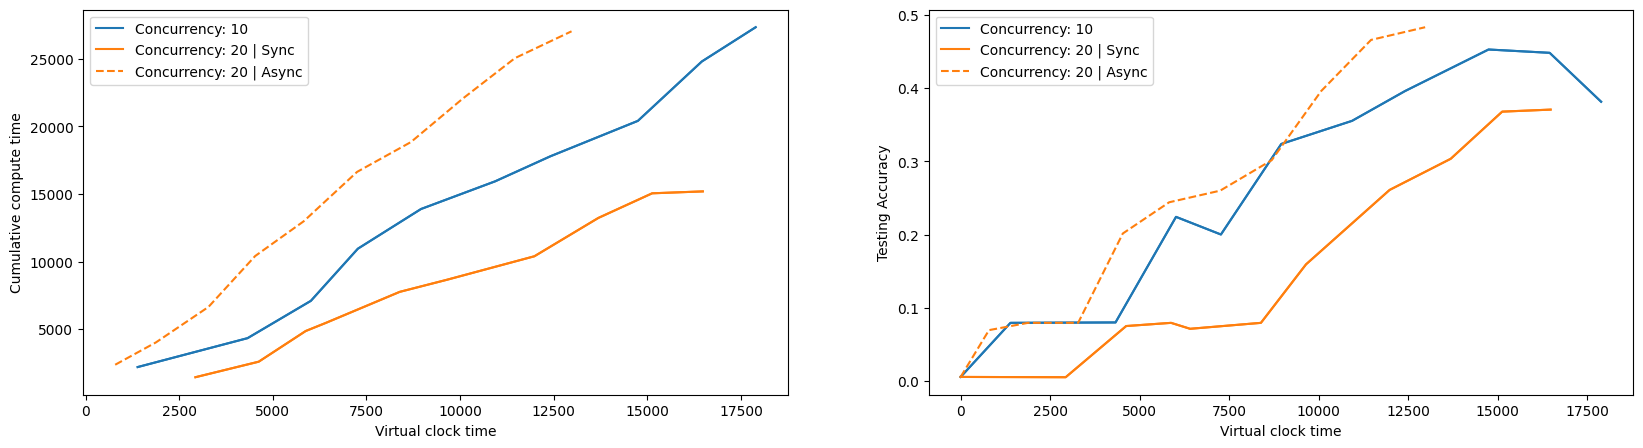

In [31]:
fig,axs =  plt.subplots(1,2,figsize=(20,5))
# axs[0].set_ylabel("Cumulative communication time")
axs[0].set_ylabel("Cumulative compute time")
axs[1].set_ylabel("Testing Accuracy")

eval_times, communication, compute_units, accuracies = get_simulation_data(False,10)
# axs[0].plot(eval_times[1:],np.cumsum(communication))
axs[0].plot(eval_times[1:],np.cumsum(compute_units))
axs[1].plot(eval_times,accuracies)

eval_times, communication, compute_units, accuracies = get_simulation_data(False,20)
# axs[0].plot(eval_times[1:],np.cumsum(communication))
axs[0].plot(eval_times[1:],np.cumsum(compute_units))
axs[1].plot(eval_times,accuracies)


for concurrency, colour in zip([10,20],["tab:blue","tab:orange"]):
  if concurrency > 10:
    eval_times, communication, compute_units, accuracies = get_simulation_data(False,concurrency)
    # axs[0].plot(eval_times[1:],np.cumsum(communication), label=f"Concurrency: {concurrency} | Sync", c=colour)
    axs[0].plot(eval_times[1:],np.cumsum(compute_units), label=f"Concurrency: {concurrency} | Sync", c=colour)
    axs[1].plot(eval_times,accuracies, label=f"Concurrency: {concurrency} | Sync", c=colour)
    eval_times, communication, compute_units, accuracies = get_simulation_data(True,concurrency)
    # axs[0].plot(eval_times[1:],np.cumsum(communication), label=f"Concurrency: {concurrency} | Async", c=colour, linestyle="--")
    axs[0].plot(eval_times[1:],np.cumsum(compute_units), label=f"Concurrency: {concurrency} | Async", c=colour, linestyle="--")
    axs[1].plot(eval_times,accuracies, label=f"Concurrency: {concurrency} | Async", c=colour, linestyle="--")
  else:
    eval_times, communication, compute_units, accuracies = get_simulation_data(False,concurrency)
    # axs[0].plot(eval_times[1:],np.cumsum(communication), label=f"Concurrency: {concurrency}", c=colour)
    axs[0].plot(eval_times[1:],np.cumsum(compute_units), label=f"Concurrency: {concurrency}", c=colour)
    axs[1].plot(eval_times,accuracies, label=f"Concurrency: {concurrency}", c=colour)

for a in axs:
  a.set_xlabel("Virtual clock time")
  a.legend()
  # a.set_ylim(0,0.5)
  # a.set_xlim(0,200)
fig.show()

/tmp/ipykernel_3818/1557936958.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


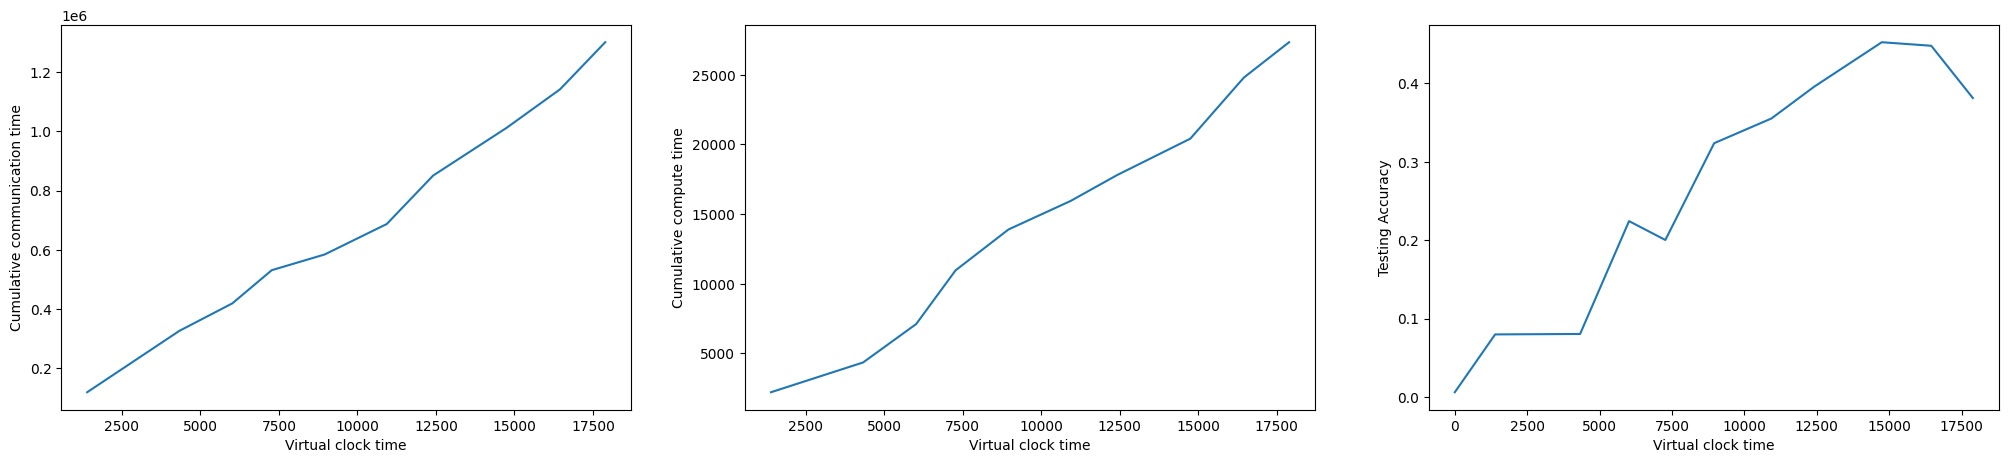

In [34]:
fig,axs =  plt.subplots(1,3,figsize=(25,5))
# axs[0].set_ylabel("Cumulative training samples")
# axs[0].plot(sync_eval_times[1:],np.cumsum(sync_training_samples_per_round))
axs[0].set_ylabel("Cumulative communication time")
axs[0].plot(sync_eval_times[1:],np.cumsum(sync_communication))
axs[1].set_ylabel("Cumulative compute time")
axs[1].plot(sync_eval_times[1:],np.cumsum(sync_compute_units))
axs[2].set_ylabel("Testing Accuracy")
axs[2].plot(sync_eval_times,sync_accuracies)
for a in axs:
  a.set_xlabel("Virtual clock time")
fig.show()